In [1]:
import pandas as pd
import numpy as np

import glob

from pathlib import Path
import csv

import os
import requests
import json

import quandl
#from iexfinance.stocks import Stock

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
## Stats Libraries
from collections import Counter
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# from imblearn.metrics import classification_report_imbalanced

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
## Goal of this file is to load price data for a given stock, and run historical stat analysis using the Closing Price 

In [4]:
## Constants 

## Set start date variable - dataframes will be created starting from this date
start_date = '2020-01-01'
end_date = '2021-11-09'
default_date_range = '2y' ## Default Range for IEX functions - don't need more at the moment

In [5]:
## QUANDL/NASDAQ 
nsdq_api_key = os.environ.get('NASDAQ_API_KEY')
base_url_nsdq = 'https://data.nasdaq.com/api/v3/datasets/FINRA/'

# ## Test iexfinance.stocks library setup and stability - should not be needed for this file 
# iex_token = os.getenv("IEX_TOKEN")
# iex_api_ver = os.getenv("IEX_API_VERSION")
# iex_out_form = os.getenv("IEX_OUTPUT_FORMAT")

iex_api_key = os.getenv("IEX_API_KEY")
iex_test_api_key = os.getenv("IEX_TEST_API_KEY")

real_token = iex_api_key
test_token = iex_test_api_key

base_url_iex = 'https://cloud.iexapis.com/stable/'
sandbox_url = 'https://sandbox.iexapis.com/stable/'

## IEX Status Test 
test_resp = requests.get(base_url_iex + 'status')
test_resp

<Response [200]>

In [6]:
# ## Check for Real vs Sandbox - throw error if Real 
# ## Check sandbox vs stable 

# #error_variable = iex_api_ver

# if iex_api_ver == 'stable':
#     print(error_variable)                  ## This file isn't meant for Real Calls at-the-moment 
# elif iex_api_ver == 'iexcloud-sandbox':
#     print('iexcloud-sandbox TESTING')
# else:
#     print('PROBLEM')

In [7]:
def get_iex_data(symbol,date_range=default_date_range):
    iex_data = Stock(symbol).get_historical_prices(range='2y',chartCloseOnly=True)

    ## This names the date/index as "Date"
    iex_data.reset_index(inplace=True)
    iex_data.rename(columns={'index':'Date'},inplace=True)
    iex_data['Date'] = pd.to_datetime(iex_data['Date'])
    iex_data.set_index('Date',inplace=True)
    
    return iex_data

def slice_iex_by_date(start_date1=start_date,end_date1=end_date):
    iex_data = iex_data[start_date1:end_date1]
    return iex_data

## IEX Calls and Functions 

def get_chart(stock_ticker, chart_range=default_date_range,token=test_token):
    
    if token == test_token:
        resp_data = requests.get(sandbox_url+'stock/'+stock_ticker+'/chart/'+chart_range+'?chartCloseOnly=true&token='+test_token)
        df = pd.DataFrame(resp_data.json())
    elif token == real_token:
        resp_data = requests.get(base_url_iex+'stock/'+stock_ticker+'/chart/'+chart_range+'?chartCloseOnly=true&token='+real_token)
        df = pd.DataFrame(resp_data.json())

    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    
    return df

In [8]:
token_status = real_token

gme_df = get_chart('GME',token=token_status)
gme_df

,close,volume,change,changePercent,changeOverTime
Date,,,,,
2019-11-11,6.02,3109457,0.00,0.0000,0.000000
2019-11-12,5.92,1834485,-0.10,-0.0166,-0.016611
2019-11-13,5.94,1533919,0.02,0.0034,-0.013289
2019-11-14,5.98,1708735,0.04,0.0067,-0.006645
2019-11-15,5.88,2166051,-0.10,-0.0167,-0.023256
...,...,...,...,...,...
2021-11-02,206.99,3882336,6.90,0.0345,33.383721
2021-11-03,218.33,11265594,11.34,0.0548,35.267442
2021-11-04,217.84,2907976,-0.49,-0.0022,35.186047


In [9]:
## Decomposition using a Hodrick-Prescott Filter



# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
# YOUR CODE HERE!
ts_noise, ts_trend = sm.tsa.filters.hpfilter(gme_df['close'])

In [10]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
new_df = gme_df[['close']]
new_df['noise'] = ts_noise
new_df['trend'] = ts_trend
new_df.head()

C:\Users\watso\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\watso\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,close,noise,trend
Date,,,
2019-11-11,6.02,0.204801,5.815199
2019-11-12,5.92,0.089898,5.830102
2019-11-13,5.94,0.094867,5.845133
2019-11-14,5.98,0.119524,5.860476
2019-11-15,5.88,0.003625,5.876375


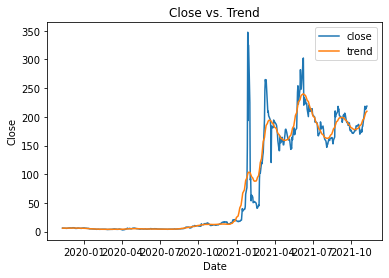

In [11]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!

plt.plot(new_df['close'],label='close')
plt.plot(new_df['trend'],label='trend')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Close vs. Trend')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

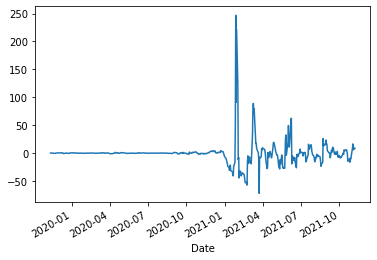

In [12]:
# Plot the Settle Noise
# YOUR CODE HERE!
ts_noise.plot()

In [13]:
## Forecasting Resturns using an ARMA Model 

# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (gme_df[["close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,close
Date,
2021-11-02,3.448448
2021-11-03,5.478526
2021-11-04,-0.224431
2021-11-05,-2.107051
2021-11-08,2.527550


In [14]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model = ARMA(returns['close'], order=(2,1))
# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results = model.fit()

C:\Users\watso\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\watso\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has n

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                  502
Model:                     ARMA(2, 1)   Log Likelihood               -1994.348
Method:                       css-mle   S.D. of innovations             12.856
Date:                Wed, 10 Nov 2021   AIC                           3998.696
Time:                        01:44:54   BIC                           4019.789
Sample:                             0   HQIC                          4006.971
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4180      0.786      1.804      0.071      -0.123       2.959
ar.L1.close     0.3028      0.133      2.282      0.023       0.043       0.563
ar.L2.close     0.1474      0.047      3.166      0.002       0.056       0.239
ma.L1.close    -0.2456      0.129     -1.911      0.056      -0.498       0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7728           +0.0000j            1.7728            0.0000
AR.2           -3.8268           +0.0000j            3.8268            0.5000
MA.1            4.0720           +0.0000j            4.0720            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

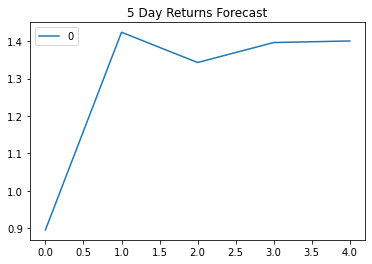

In [16]:
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

In [17]:
df = gme_df.copy()
df['Return'] = df.close.pct_change() * 100
df['Lagged_Return'] = df['Return'].shift()
df = df.replace(-np.inf, np.nan).dropna()
df = df.reset_index()
df

,Date,close,volume,change,changePercent,changeOverTime,Return,Lagged_Return
0,2019-11-13,5.94,1533919,0.02,0.0034,-0.013289,0.337838,-1.661130
1,2019-11-14,5.98,1708735,0.04,0.0067,-0.006645,0.673401,0.337838
2,2019-11-15,5.88,2166051,-0.10,-0.0167,-0.023256,-1.672241,0.673401
3,2019-11-18,5.62,2995894,-0.26,-0.0442,-0.066445,-4.421769,-1.672241
4,2019-11-19,5.50,3360548,-0.12,-0.0214,-0.086379,-2.135231,-4.421769
...,...,...,...,...,...,...,...,...
496,2021-11-02,206.99,3882336,6.90,0.0345,33.383721,3.448448,9.034930
497,2021-11-03,218.33,11265594,11.34,0.0548,35.267442,5.478526,3.448448
498,2021-11-04,217.84,2907976,-0.49,-0.0022,35.186047,-0.224431,5.478526
499,2021-11-05,213.25,1810717,-4.59,-0.0211,34.423588,-2.107051,-0.224431


In [18]:
# train = df['2019':'2021-11-04']
# test = df['2021-11-05':]

train = df[0:496]
test = df[496:]

In [19]:
test

,Date,close,volume,change,changePercent,changeOverTime,Return,Lagged_Return
496,2021-11-02,206.99,3882336,6.90,0.0345,33.383721,3.448448,9.034930
497,2021-11-03,218.33,11265594,11.34,0.0548,35.267442,5.478526,3.448448
498,2021-11-04,217.84,2907976,-0.49,-0.0022,35.186047,-0.224431,5.478526
499,2021-11-05,213.25,1810717,-4.59,-0.0211,34.423588,-2.107051,-0.224431
500,2021-11-08,218.64,2157912,5.39,0.0253,35.318937,2.527550,-2.107051


In [20]:
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

In [21]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [23]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

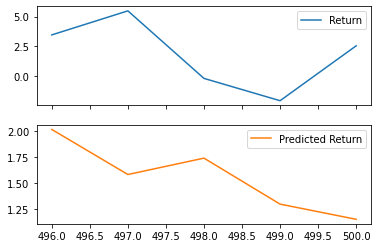

In [24]:
# Plot the first 20 predictions vs the true values
Results.plot(subplots=True)